In [1]:
from scipy.io import wavfile

(source_clean_fs, source_clean_data) = wavfile.read('./data/source_clean.wav')
(plini_clean_fs, plini_clean_data) = wavfile.read('./data/plini_clean.wav')
(source_noise_fs, source_noise_data) = wavfile.read('./data/source_noise.wav')
(plini_noise_fs, plini_noise_data) = wavfile.read('./data/plini_noise.wav')

In [2]:
import pandas as pd

In [3]:
source_clean_df = pd.DataFrame(source_clean_data, columns=['L', 'R'])
source_clean_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [4]:
plini_clean_df = pd.DataFrame(plini_clean_data, columns=['L', 'R'])
plini_clean_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [5]:
source_noise_df = pd.DataFrame(source_noise_data, columns=['L', 'R'])
source_noise_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [6]:
plini_noise_df = pd.DataFrame(plini_noise_data, columns=['L', 'R'])
plini_noise_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [7]:
plini_clean_df['L'].max(), plini_noise_df['L'].max()

(32767, 29669)

In [8]:
2 ** 15

32768

In [9]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [10]:
len(plini_clean_df), len(source_clean_df)

(2442240, 2442240)

In [11]:
len(plini_noise_df), len(source_noise_df)

(814464, 814464)

In [12]:
CLEAN_START_END = int(len(plini_clean_df) * 0.8)
CLEAN_START_END

1953792

In [13]:
NOISE_START_END = int(len(plini_noise_df) * 0.8)
NOISE_START_END

651571

In [24]:
(X_train_c_start, X_train_c_end) = (0, CLEAN_START_END)
(X_test_c_start, X_test_c_end) = (CLEAN_START_END, len(source_clean_df))
(y_train_c_start, y_train_c_end) = (0, CLEAN_START_END)
(y_test_c_start, y_test_c_end) = (CLEAN_START_END, len(plini_clean_df))

In [25]:
(X_train_n_start, X_train_n_end) = (0, NOISE_START_END)
(X_test_n_start, X_test_n_end) = (NOISE_START_END, len(source_noise_df))
(y_train_n_start, y_train_n_end) = (0, NOISE_START_END)
(y_test_n_start, y_test_n_end) = (NOISE_START_END, len(source_noise_df))

## IT'S MONO

In [26]:
X_train_c_raw = source_clean_df['L'][X_train_c_start:X_train_c_end]
X_train_c_raw.head()

0    0
1    0
2    0
3    0
4    0
Name: L, dtype: int16

In [27]:
X_test_c_raw = source_clean_df['L'][X_test_c_start:X_test_c_end]
X_test_c_raw.head()

1953792   -615
1953793   -560
1953794   -485
1953795   -395
1953796   -302
Name: L, dtype: int16

In [28]:
y_train_c_raw = plini_clean_df['L'][y_train_c_start:y_train_c_end]
y_train_c_raw.head()

0    0
1    0
2    0
3    0
4    0
Name: L, dtype: int16

In [29]:
y_test_c_raw = plini_clean_df['L'][y_test_c_start:y_test_c_end]
y_test_c_raw.head()

1953792    576
1953793    807
1953794    559
1953795    206
1953796    178
Name: L, dtype: int16

In [26]:
X_train_c_raw = source_clean_df['L'][X_train_c_start:X_train_c_end]
X_train_c_raw.head()

0    0
1    0
2    0
3    0
4    0
Name: L, dtype: int16

In [27]:
X_test_c_raw = source_clean_df['L'][X_test_c_start:X_test_c_end]
X_test_c_raw.head()

1953792   -615
1953793   -560
1953794   -485
1953795   -395
1953796   -302
Name: L, dtype: int16

In [28]:
y_train_c_raw = plini_clean_df['L'][y_train_c_start:y_train_c_end]
y_train_c_raw.head()

0    0
1    0
2    0
3    0
4    0
Name: L, dtype: int16

In [29]:
y_test_c_raw = plini_clean_df['L'][y_test_c_start:y_test_c_end]
y_test_c_raw.head()

1953792    576
1953793    807
1953794    559
1953795    206
1953796    178
Name: L, dtype: int16

In [31]:
X_train_n_raw = source_noise_df['L'][X_train_n_start:X_train_n_end]
X_train_n_raw.head()

0    0
1    0
2    0
3    0
4    0
Name: L, dtype: int16

In [32]:
X_test_n_raw = source_noise_df['L'][X_test_n_start:X_test_n_end]
X_test_n_raw.head()

651571    -4
651572    -9
651573   -16
651574   -19
651575   -19
Name: L, dtype: int16

In [33]:
y_train_n_raw = plini_noise_df['L'][y_train_n_start:y_train_n_end]
y_train_n_raw.head()

0    0
1    0
2    0
3    0
4    0
Name: L, dtype: int16

In [34]:
y_test_n_raw = plini_noise_df['L'][y_test_n_start:y_test_n_end]
y_test_n_raw.head()

651571    7847
651572    -430
651573   -4769
651574    4381
651575    3236
Name: L, dtype: int16

In [35]:
TR_C_N_DEV = source_clean_fs
TR_C_OFFSET_DEV = source_clean_fs * 2

TE_C_N_DEV = int(source_clean_fs / 8)
TE_C_OFFSET_DEV = source_clean_fs * 2

In [58]:
TR_N_N_DEV = source_noise_fs
TR_N_OFFSET_DEV = source_noise_fs * 2

TE_N_N_DEV = int(TE_C_N_DEV / 10)
TE_N_OFFSET_DEV = source_noise_fs * 2

In [59]:
(TR_C_N_DEV, TE_C_N_DEV, TR_N_N_DEV, TE_N_N_DEV)

(44100, 5512, 44100, 551)

In [377]:
# N_WINDOW_POINTS = int(source_clean_fs * 0.02)
N_WINDOW_POINTS = 64
N_WINDOW_POINTS

64

In [378]:
def make_windows(df, n_window_points):
    df_index = df.index
    index = 0
    windows = []

    for index in range(0, len(df) - n_window_points):
        windows.append(df_index[index:(index + n_window_points)])

    return windows

In [379]:
X_train_c_wnd = make_windows(X_train_c_raw[TR_C_OFFSET_DEV:TR_C_OFFSET_DEV+TR_C_N_DEV], N_WINDOW_POINTS)
len(X_train_c_wnd)

44036

In [380]:
X_test_c_wnd = make_windows(X_test_c_raw[TE_C_OFFSET_DEV:TE_C_OFFSET_DEV+TE_C_N_DEV], N_WINDOW_POINTS)
len(X_test_c_wnd)

5448

In [381]:
y_train_c_wnd = make_windows(y_train_c_raw[TR_C_OFFSET_DEV:TR_C_OFFSET_DEV+TR_C_N_DEV], N_WINDOW_POINTS)
len(y_train_c_wnd)

44036

In [382]:
y_test_c_wnd = make_windows(y_test_c_raw[TE_C_OFFSET_DEV:TE_C_OFFSET_DEV+TE_C_N_DEV], N_WINDOW_POINTS)
len(y_test_c_wnd)

5448

In [383]:
X_train_n_wnd = make_windows(X_train_n_raw[TR_N_OFFSET_DEV:TR_N_OFFSET_DEV+TR_N_N_DEV], N_WINDOW_POINTS)
len(X_train_n_wnd)

44036

In [384]:
X_test_n_wnd = make_windows(X_test_n_raw[TE_N_OFFSET_DEV:TE_N_OFFSET_DEV+TE_N_N_DEV], N_WINDOW_POINTS)
len(X_test_n_wnd)

487

In [385]:
y_train_n_wnd = make_windows(y_train_n_raw[TR_N_OFFSET_DEV:TR_N_OFFSET_DEV+TR_N_N_DEV], N_WINDOW_POINTS)
len(y_train_n_wnd)

44036

In [386]:
y_test_n_wnd = make_windows(y_test_n_raw[TE_N_OFFSET_DEV:TE_N_OFFSET_DEV+TE_N_N_DEV], N_WINDOW_POINTS)
len(y_test_n_wnd)

487

In [387]:
X_test_c_wnd[0]

RangeIndex(start=2041992, stop=2042056, step=1)

In [388]:
X_test_c_raw[X_test_c_wnd[0]]

2041992     153
2041993     147
2041994     154
2041995     176
2041996     215
2041997     279
2041998     358
2041999     443
2042000     539
2042001     625
2042002     696
2042003     755
2042004     791
2042005     801
2042006     790
2042007     755
2042008     691
2042009     598
2042010     478
2042011     333
2042012     169
2042013      -6
2042014    -183
2042015    -360
2042016    -528
2042017    -681
2042018    -813
2042019    -926
2042020   -1016
2042021   -1084
           ... 
2042026   -1082
2042027   -1046
2042028   -1002
2042029    -955
2042030    -902
2042031    -845
2042032    -791
2042033    -742
2042034    -694
2042035    -644
2042036    -589
2042037    -525
2042038    -453
2042039    -378
2042040    -309
2042041    -250
2042042    -204
2042043    -170
2042044    -141
2042045    -115
2042046     -91
2042047     -71
2042048     -58
2042049     -58
2042050     -71
2042051     -95
2042052    -120
2042053    -146
2042054    -169
2042055    -188
Name: L, Length: 64, dty

## Preparing data for processing

In [419]:
X_train = (
    list(map(lambda wnd: X_train_c_raw[wnd], X_train_c_wnd)) +
    list(map(lambda wnd: X_train_n_raw[wnd], X_train_n_wnd))
)

X_train[0], X_train[-1]

(88200    -725
 88201    -877
 88202    -986
 88203   -1013
 88204    -959
 88205    -815
 88206    -628
 88207    -424
 88208    -218
 88209     -28
 88210     151
 88211     303
 88212     431
 88213     534
 88214     615
 88215     671
 88216     707
 88217     751
 88218     842
 88219     990
 88220    1158
 88221    1316
 88222    1448
 88223    1559
 88224    1660
 88225    1754
 88226    1793
 88227    1738
 88228    1584
 88229    1357
          ... 
 88234     145
 88235     -87
 88236    -274
 88237    -416
 88238    -514
 88239    -565
 88240    -592
 88241    -576
 88242    -540
 88243    -500
 88244    -454
 88245    -398
 88246    -337
 88247    -263
 88248    -176
 88249     -94
 88250       3
 88251      96
 88252     190
 88253     267
 88254     319
 88255     365
 88256     400
 88257     443
 88258     482
 88259     512
 88260     504
 88261     474
 88262     451
 88263     421
 Name: L, Length: 64, dtype: int16, 132235    -8
 132236    -4
 132237   -10
 132238 

In [420]:
X_test = (
    list(map(lambda wnd: X_test_c_raw[wnd], X_test_c_wnd)) +
    list(map(lambda wnd: X_test_n_raw[wnd], X_test_n_wnd))
)

X_test[0], X_test[-1]

(2041992     153
 2041993     147
 2041994     154
 2041995     176
 2041996     215
 2041997     279
 2041998     358
 2041999     443
 2042000     539
 2042001     625
 2042002     696
 2042003     755
 2042004     791
 2042005     801
 2042006     790
 2042007     755
 2042008     691
 2042009     598
 2042010     478
 2042011     333
 2042012     169
 2042013      -6
 2042014    -183
 2042015    -360
 2042016    -528
 2042017    -681
 2042018    -813
 2042019    -926
 2042020   -1016
 2042021   -1084
            ... 
 2042026   -1082
 2042027   -1046
 2042028   -1002
 2042029    -955
 2042030    -902
 2042031    -845
 2042032    -791
 2042033    -742
 2042034    -694
 2042035    -644
 2042036    -589
 2042037    -525
 2042038    -453
 2042039    -378
 2042040    -309
 2042041    -250
 2042042    -204
 2042043    -170
 2042044    -141
 2042045    -115
 2042046     -91
 2042047     -71
 2042048     -58
 2042049     -58
 2042050     -71
 2042051     -95
 2042052    -120
 2042053    -1

In [421]:
y_train = (
    list(map(lambda wnd: y_train_c_raw[wnd], y_train_c_wnd)) +
    list(map(lambda wnd: y_train_n_raw[wnd], y_train_n_wnd))
)

y_train[0], y_train[-1]

(88200    1118
 88201     258
 88202     145
 88203     854
 88204     896
 88205     -54
 88206   -1922
 88207   -3178
 88208   -1751
 88209    1715
 88210    4552
 88211    4313
 88212    2005
 88213    -137
 88214   -1049
 88215     866
 88216    3828
 88217    4486
 88218    2774
 88219      42
 88220   -1738
 88221   -1592
 88222     -35
 88223    1778
 88224    2595
 88225    1983
 88226    1740
 88227    1965
 88228    1299
 88229    1925
          ... 
 88234    -442
 88235    1143
 88236    3186
 88237    4384
 88238    3292
 88239    -477
 88240   -2510
 88241    -662
 88242    3925
 88243    7671
 88244    6696
 88245    3316
 88246     803
 88247    1191
 88248    3828
 88249    5551
 88250    5037
 88251    3819
 88252    3078
 88253    2579
 88254    2618
 88255    2391
 88256    2255
 88257    2113
 88258    1952
 88259    2723
 88260    2672
 88261    1317
 88262     712
 88263    1208
 Name: L, Length: 64, dtype: int16, 132235    -2461
 132236     1274
 132237     4151

In [422]:
y_test = (
    list(map(lambda wnd: y_test_c_raw[wnd], y_test_c_wnd)) +
    list(map(lambda wnd: y_test_n_raw[wnd], y_test_n_wnd))
)

y_test[0], y_test[-1]

(2041992    1572
 2041993     314
 2041994    -408
 2041995    -288
 2041996    -101
 2041997    -390
 2041998   -1198
 2041999   -2009
 2042000   -2520
 2042001   -2666
 2042002   -2592
 2042003   -2741
 2042004   -2906
 2042005   -2911
 2042006   -2718
 2042007   -2175
 2042008   -1581
 2042009   -1250
 2042010   -1388
 2042011   -1692
 2042012   -1780
 2042013   -1656
 2042014   -1289
 2042015    -987
 2042016    -755
 2042017    -609
 2042018    -437
 2042019    -199
 2042020     -61
 2042021      19
            ... 
 2042026     336
 2042027     288
 2042028     476
 2042029     254
 2042030    -152
 2042031     229
 2042032     748
 2042033     953
 2042034     871
 2042035     455
 2042036    -128
 2042037    -425
 2042038    -205
 2042039     534
 2042040     549
 2042041     -71
 2042042    -413
 2042043    -554
 2042044    -291
 2042045       9
 2042046     611
 2042047     561
 2042048    -444
 2042049    -614
 2042050    -416
 2042051    -173
 2042052     333
 2042053     2

In [423]:
train_shuffle_index = np.arange(0, len(X_train))
np.random.shuffle(train_shuffle_index)

test_shuffle_index = np.arange(0, len(X_test))
np.random.shuffle(test_shuffle_index)

X_train = np.array(X_train)[train_shuffle_index]
y_train = np.array(y_train)[train_shuffle_index]

X_test = np.array(X_test)[test_shuffle_index]
y_test = np.array(y_test)[test_shuffle_index]

X_train[0], y_train[0]

(array([12, 25, 22, 30, 45, 17, 18, 17, 22, 21, 21, 27, 12, 16, 22, 21,  6,
         8,  5,  8, 24,  6,  5, 16, 13, 16, 16, 24, 29, 31, 37, 26, 28, 33,
        34, 36, 33, 33, 26, 26, 19, 17,  1, -6,  5, -7,  2,  7, 13, 23,  6,
         7, 19, 18, 19, 10,  7, -1,  9, 19,  5, 23,  6,  2], dtype=int16),
 array([ -5339,   -254,   2537,  -2629,  -2783,   6859,   -448,  -4081,
         -7318,  -5167,   9471,   7116,   2370, -11311, -10961,   8825,
          1113,  -2282,   7284,  -1966,  -5726,  -1076,   -976,   2636,
          2928,   3504,    952, -10151,  -7856,   2850,   5165,   3055,
          -559,  -3498,  -4965,   6687,   6325,  -7342,  -6869,  -6354,
          4126,   9635,   4947,  -1520,  -7891,  -3876,    619,   7336,
          5682,  -7423, -11697,   5632,   9048,  -3092,   3176,    697,
        -11574,   -994,   9185,   2206,  -2236,  -9137,   1638,   9978],
       dtype=int16))

In [424]:
def normalize_keeping_mean(arr, forced_abs=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
    
    return np.clip(arr / n, -1.0, 1.0)

In [425]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [426]:
import numpy as np

X_tr = np.array(list(map(lambda x: np.array(x), X_train)))
X_tr_n = normalize(X_tr, forced_abs=MAX_VALUE, mean=0.0)
X_tr_n.min(), X_tr_n.max(), np.mean(X_tr_n)

(-0.07431257057405316, 0.09094515823847163, 2.5463454694080666e-05)

In [427]:
X_te = np.array(list(map(lambda x: np.array(x), X_test)))
X_te_n = normalize_keeping_mean(X_te, forced_abs=MAX_VALUE)
X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.05261391033661916, 0.04519791253395184, -5.329080997692491e-05)

In [428]:
y_tr = np.array(list(map(lambda x: np.array(x), y_train)))
y_tr_n = normalize_keeping_mean(y_tr, forced_abs=MAX_VALUE)
y_tr_n.min(), y_tr_n.max(), np.mean(y_tr_n)

(-0.6644795068208869, 0.7200231940672017, -1.735796643865174e-05)

In [429]:
y_te = np.array(list(map(lambda x: np.array(x), y_test)))
y_te_n = normalize_keeping_mean(y_te, forced_abs=MAX_VALUE)
y_te_n.min(), y_te_n.max(), np.mean(y_te_n)

(-0.5569322794274728, 0.6695455793939024, 4.3853725812506534e-05)

In [430]:
X_tr_n = X_tr_n.astype('float32')
X_te_n = X_te_n.astype('float32')
y_tr_n = y_tr_n.astype('float32')
y_te_n = y_te_n.astype('float32')

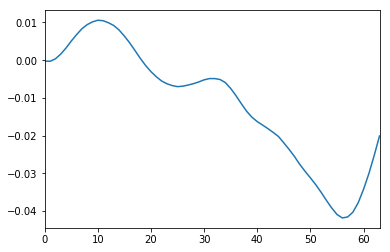

In [431]:
pd.Series(X_tr_n[-100]).plot.line()

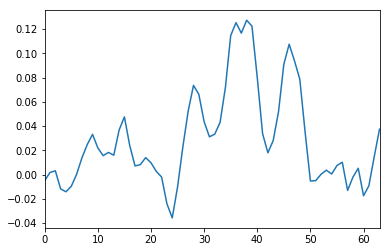

In [432]:
pd.Series(y_tr_n[-100]).plot.line()

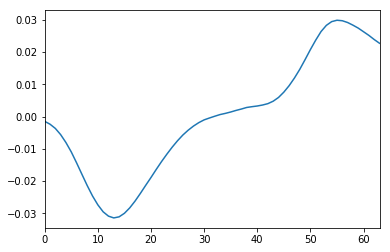

In [433]:
pd.Series(X_te_n[-100]).plot.line()

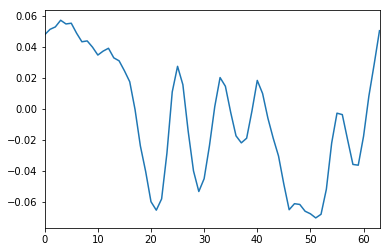

In [434]:
pd.Series(y_te_n[-100]).plot.line()

## Need to apply FFT to data

The plan is to apply FFT, and take the freqs and amplitudes of first N peaks, feeding it into NN

In [654]:
test_wnd = X_te[1]
test_wnd

array([ -152,  -134,  -104,   -64,   -22,    22,    61,    94,   120,
         142,   167,   199,   240,   285,   333,   373,   407,   431,
         448,   469,   487,   510,   525,   528,   521,   497,   464,
         422,   381,   342,   309,   276,   235,   184,   111,    19,
         -91,  -218,  -351,  -486,  -623,  -754,  -870,  -972, -1053,
       -1109, -1136, -1131, -1099, -1040,  -963,  -878,  -786,  -697,
        -611,  -532,  -458,  -394,  -344,  -305,  -277,  -253,  -233,
        -217], dtype=int16)

In [655]:
FD = 22050 * 2
FD

44100

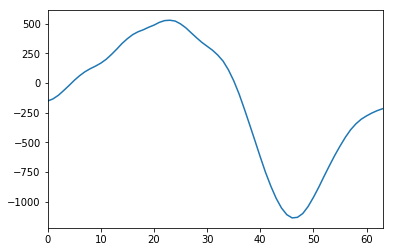

In [656]:
pd.Series(test_wnd).plot.line()

In [657]:
from numpy.fft import rfft, fftfreq, rfftfreq

freq = rfftfreq(32, 1./FD)
max_freq = freq[-1]

print(max_freq)

fft = rfft(test_wnd)

df = pd.Series(fft)

index = []

for i in range(0, len(fft)):
    index = index + [(i / len(fft)) * max_freq]

print(index)

df.index = index

22050.0
[0.0, 668.1818181818182, 1336.3636363636365, 2004.5454545454545, 2672.727272727273, 3340.909090909091, 4009.090909090909, 4677.272727272727, 5345.454545454546, 6013.636363636363, 6681.818181818182, 7350.0, 8018.181818181818, 8686.363636363636, 9354.545454545454, 10022.727272727272, 10690.909090909092, 11359.090909090908, 12027.272727272726, 12695.454545454546, 13363.636363636364, 14031.818181818182, 14700.0, 15368.18181818182, 16036.363636363636, 16704.545454545456, 17372.727272727272, 18040.909090909092, 18709.090909090908, 19377.272727272728, 20045.454545454544, 20713.636363636364, 21381.818181818184]


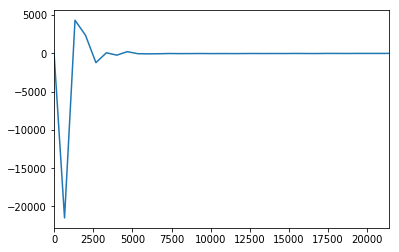

In [658]:
df.map(lambda x: x.imag).plot.line()

/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


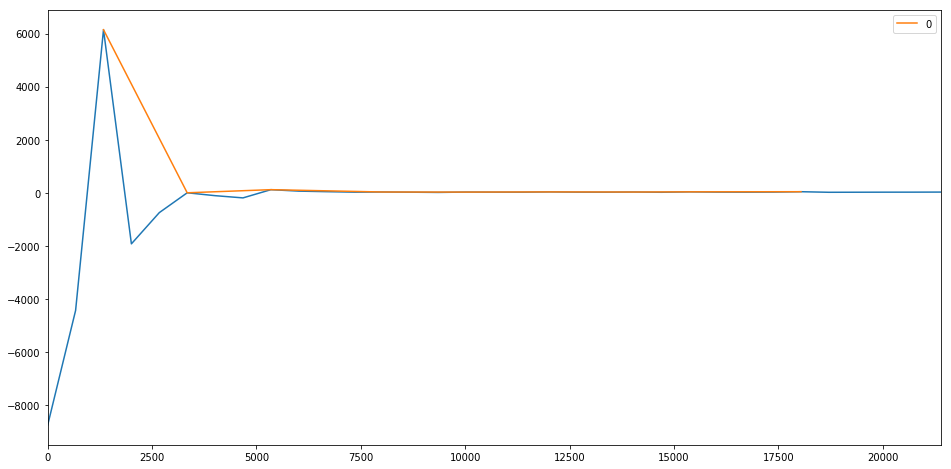

In [659]:
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

(fig, ax) = plt.subplots(figsize=(16, 8))
df.plot.line(ax=ax)

peaks_re = find_peaks(df.map(lambda x: x.real))[0]
peaks_im = find_peaks(df.map(lambda x: x.imag))[0]

pd.DataFrame(df.iloc[peaks_re]).plot.line(ax=ax)

In [660]:
def append_peaks(df, peaks, N):
    res = df.iloc[peaks[:N]]

    for i in range(len(peaks), N_PEAKS):
        res = res.append(pd.Series([0], index=[0]))
        
    return res

In [661]:
peaks_re

array([ 2,  5,  8, 12, 15, 18, 21, 23, 27])

In [662]:
N_PEAKS = 10

peaks_re = append_peaks(df, peaks_re, N_PEAKS)
peaks_im = append_peaks(df, peaks_im, N_PEAKS)

(peaks_re, peaks_im)

(1336.363636         (6148.852728706128+4333.466996841857j)
 3340.909091     (-0.039995069815738304+82.38138881696844j)
 5345.454545       (117.96194077712559-36.748737341529164j)
 8018.181818        (29.65614985930344-25.962388980565038j)
 10022.727273      (27.171823643356674-24.396174248229727j)
 12027.272727       (33.40444048999893-19.786936745616458j)
 14031.818182      (29.202062680448066-12.681798793617777j)
 15368.181818       (36.007268722068964-6.875648105518664j)
 18040.909091       (41.021860971976444-4.111674490044493j)
 0.000000                                                0j
 dtype: complex128, 1336.363636         (6148.852728706128+4333.466996841857j)
 3340.909091     (-0.039995069815738304+82.38138881696844j)
 4677.272727        (-192.04812233719966+228.818847814338j)
 7350.000000        (24.83740211054719-13.961313552004182j)
 9354.545455       (14.000579442918252-14.692520353491545j)
 10690.909091                                      (24-19j)
 12695.454545      (2

In [782]:
from numpy.fft import rfft, fftfreq, rfftfreq
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import librosa as lr

MAGIC_NUMBER = 22050
MAGIC_CENTROID_NUMBER = 10000
MAGIC_ROLLOFF_NUMBER = 20000

def extract_fft_features(wnd, N_PEAKS):
    # Apply FFT
    
    freq = rfftfreq(N_WINDOW_POINTS, 1./FD)
    max_freq = FD / 2
    

    fft = rfft(wnd)

    df = pd.Series(fft)

    index = []

    for i in range(0, len(fft)):
        index = index + [(i / (len(fft) - 1))]

    df.index = index

    # Output FFT
    
    real = normalize(
         np.array(list(map(lambda x: x.real, df.values))),
         forced_abs=MAGIC_NUMBER,
         mean=0.0
    )
    
    imag = normalize(
        np.array(list(map(lambda x: x.imag, df.values))),
        forced_abs=MAGIC_NUMBER,
        mean=0.0
    )
    

    res = {'df': df, 'data': np.concatenate([real, imag])}
    
    return res
    
    

def extract_spectral_features(wnd, fft_df, N_PEAKS):    
    real = np.array(list(map(lambda x: x.real, fft_df.values)))
    imag = np.array(list(map(lambda x: x.imag, fft_df.values)))
    

    # Output spectral
    
    real_stats = [
        real.mean(),
        real.std(),
        real.max(),
        real.min(),
    ]   
    
    imag_stats = [
        imag.mean(),
        imag.std(),
        imag.max(),
        imag.min(),
    ]
    
#     print(lr.onset.onset_detect(wnd.astype('float64')))
    
    stats = [
        lr.feature.spectral_centroid(wnd.astype('float64'))[0][0] / MAGIC_CENTROID_NUMBER,
        lr.feature.spectral_rolloff(wnd.astype('float64'))[0][0] / MAGIC_ROLLOFF_NUMBER
    ]

    
    # Find peaks

#     peaks_re = find_peaks(real)[0]
#     peaks_im = find_peaks(imag)[0]

#     peaks_re = append_peaks(fft_df, peaks_re, N_PEAKS)
#     peaks_im = append_peaks(fft_df, peaks_im, N_PEAKS)
    
#     print(peaks_re)
    
#     features_re = (
#          list(np.array(list(peaks_re.index))) +
#          list(normalize(np.array(list(map(lambda x: x.real, peaks_re.get_values()))), forced_abs=MAGIC_NUMBER, mean=0.0))
#     )
    
#     features_im = (
#          list(np.array(list(peaks_im.index))) +
#          list(normalize(np.array(list(map(lambda x: x.imag, peaks_im.get_values()))), forced_abs=MAGIC_NUMBER, mean=0.0))
#     )

#     res = np.concatenate([real_stats, imag_stats, features_re, features_im, stats])
    res = np.concatenate([real_stats, imag_stats, stats])
    
    return res

In [783]:
fft_res = extract_fft_features(test_wnd, N_PEAKS)
extract_spectral_features(fft_res['data'], fft_res['df'], N_PEAKS)

array([-2.79636364e+02,  2.02931603e+03,  6.14885273e+03, -8.75500000e+03,
       -4.94701681e+02,  3.81350919e+03,  4.33346700e+03, -2.14932361e+04,
        5.88984306e-01,  4.67270508e-01])

In [784]:
# it. fucking. works.
# Hail God.

In [785]:
def append_features_X(X):
    res = []
    
    for wnd in X:
        # res.append(np.array(list(wnd) + list(extract_fft_features(wnd, N_PEAKS))))
        fft = extract_fft_features(wnd, N_PEAKS)
        
        res.append(np.concatenate([
            fft['data'],
            extract_spectral_features(fft['data'], fft['df'], N_PEAKS)
        ]))
    
    return np.array(res)

def append_features_y(X):
    res = []
    
    for wnd in X:
        # res.append(np.array(list(wnd) + list(extract_fft_features(wnd, N_PEAKS))))
        fft = extract_fft_features(wnd, N_PEAKS)
        res.append(fft['data'])
    
    return np.array(res)

In [786]:
append_features_X(X_tr_n[:1])[0]

array([ 1.50862473e-06, -1.58877425e-07,  3.56393460e-07, -2.71149344e-07,
        4.84148937e-08,  1.15832286e-07, -7.27327437e-08, -3.80598311e-08,
       -8.66512547e-08, -7.36721523e-08, -1.29813056e-07, -4.30396378e-08,
       -1.68531196e-08,  1.08439086e-07, -1.72073280e-08, -5.30105788e-08,
        5.95145536e-08,  6.19156686e-08, -1.09180221e-08,  5.07882908e-08,
       -2.58728734e-08, -1.88414120e-08,  7.71854069e-08,  3.09925264e-08,
       -5.72909214e-08,  3.75560688e-08,  3.80564031e-08, -9.51337533e-08,
       -1.67613758e-08, -5.66849187e-10, -8.44214352e-09, -7.49214416e-09,
       -1.10724751e-08,  0.00000000e+00, -1.40153262e-07, -1.52996406e-07,
       -3.82901610e-08, -1.79193279e-07, -1.58854543e-08,  3.25273841e-09,
       -1.14794147e-07,  4.59830267e-09,  1.79591254e-09, -9.37108093e-08,
       -5.97561026e-08,  2.85058056e-08,  5.13643529e-08, -1.08494369e-08,
       -5.78685344e-09, -1.24565345e-08,  1.26566240e-09, -3.31942474e-08,
       -7.89690719e-08, -

In [787]:
(len(X_tr), len(X_te), len(y_tr), len(y_te))

(88072, 5935, 88072, 5935)

In [788]:
%%time

# N_DEV_2 = 10000

X_tr_f = append_features_X(X_tr_n)
print('X_tr_f finished...')

X_te_f = append_features_X(X_te_n)
print('X_te_f finished...')

y_tr_f = append_features_y(y_tr_n)
print('y_tr_f finished...')

y_te_f = append_features_y(y_te_n)
print('y_te_f finished...')

X_tr_f finished...
X_te_f finished...
y_tr_f finished...
y_te_f finished...
CPU times: user 2min 59s, sys: 2.44 s, total: 3min 1s
Wall time: 3min 3s


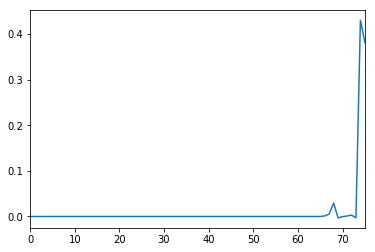

In [789]:
pd.Series(X_tr_f[100]).plot.line()

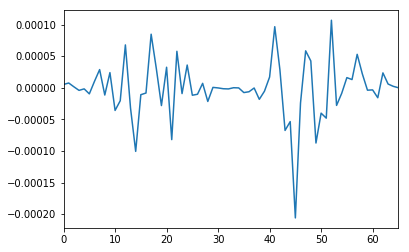

In [790]:
pd.Series(y_tr_f[100]).plot.line()

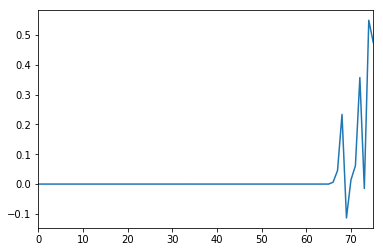

In [791]:
pd.Series(X_te_f[100]).plot.line()

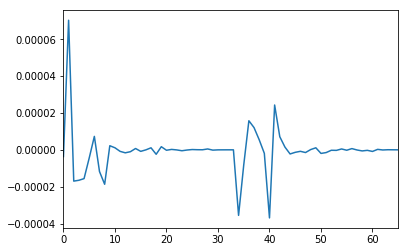

In [792]:
pd.Series(y_te_f[100]).plot.line()

In [793]:
(X_te_f[0], y_te_f[0])

(array([-3.04493065e-08, -1.39344333e-07, -1.25006212e-07,  2.09757350e-07,
         8.45024787e-08,  1.13415949e-07, -9.01498531e-09,  1.22405155e-08,
         1.10684008e-07,  1.66225159e-08,  1.72419266e-08,  3.10900905e-08,
        -8.74221906e-09,  7.21320042e-08,  3.82988328e-08,  4.78062584e-09,
         5.53623754e-08,  7.89619918e-08,  4.09300600e-08, -4.58950923e-08,
         1.34986709e-07, -1.04559747e-09,  6.27715490e-08,  6.38788100e-08,
         6.37074746e-08, -4.47760111e-08,  1.18413931e-07,  7.50631705e-08,
        -1.69786551e-08, -2.49170257e-08,  3.07073468e-10, -1.21091089e-09,
         2.76811877e-09,  0.00000000e+00, -4.86002003e-07, -3.07632602e-07,
        -2.13736887e-07, -1.01289898e-07, -3.91967681e-08, -1.15756951e-07,
        -6.08961474e-08, -5.18003697e-08, -1.59969505e-07,  4.34597913e-08,
         3.76976911e-08, -3.24772455e-08, -5.67335376e-08, -3.22984109e-08,
        -3.31376037e-08, -1.05188513e-07,  1.18695944e-07, -1.45892327e-07,
         5.8

In [796]:
# np.max(list(map(lambda row: row[65:], X_te_f)))
np.max(list(map(lambda row: row, X_te_f)))

1.1706475801643974

In [797]:
# appending stats of the whole sample, fading from silence

In [798]:
train_shuffle_index = np.random.shuffle(np.arange(0, len(X_tr_f)))
test_shuffle_index = np.random.shuffle(np.arange(0, len(X_te_f)))

X_tr_f = X_tr_f[train_shuffle_index][0]
y_tr_f = y_tr_f[train_shuffle_index][0]

X_te_f = X_te_f[test_shuffle_index][0]
y_te_f = y_te_f[test_shuffle_index][0]

In [799]:
(len(X_tr_f[0]), len(y_tr_f[0]))

(76, 66)

In [800]:
N_FEATURES_X = 76
N_FEATURES_y = 66

N_FEATURES_X, N_FEATURES_y

(76, 66)

In [801]:
list(map(lambda row: row[N_PEAKS:N_PEAKS*2], X_tr_f))[0]
# list(map(lambda row: row[:N_PEAKS], X_tr_f))[0]

array([-1.29813056e-07, -4.30396378e-08, -1.68531196e-08,  1.08439086e-07,
       -1.72073280e-08, -5.30105788e-08,  5.95145536e-08,  6.19156686e-08,
       -1.09180221e-08,  5.07882908e-08])

<Figure size 1368x1080 with 0 Axes>

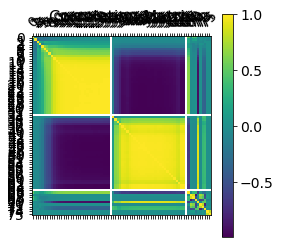

In [802]:
# amp_df = pd.DataFrame(list(map(lambda row: row[N_PEAKS:N_PEAKS*2], X_tr_f)))
amp_df = pd.DataFrame(list(map(lambda row: row, X_tr_f)))

f = plt.figure(figsize=(19, 15))
plt.matshow(amp_df.corr())
plt.xticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14, rotation=45)
plt.yticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## Finished data processing!

## Moving on to training NN

In [803]:
import numpy as np

In [804]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [805]:
y_tr_f.shape, X_tr_f.shape, X_te_f.shape, y_te_f.shape

((88072, 66), (88072, 76), (5935, 76), (5935, 66))

In [806]:
y_tr_f[0]

array([-2.18252327e-05,  2.48636547e-06, -1.96955612e-06,  9.68172255e-06,
        5.15012602e-06, -2.59266139e-06,  4.06798378e-05, -2.76252888e-05,
        3.25538023e-05, -7.11860579e-05, -7.22856483e-05,  1.94435926e-04,
        6.38403481e-05,  2.37462607e-05, -3.53565385e-05, -3.54140509e-05,
       -3.97889389e-05, -5.23617595e-05, -4.26024687e-05, -7.85917138e-05,
        2.97760733e-05,  1.01631848e-05, -9.88541009e-06, -9.29809596e-05,
       -3.86215193e-05,  2.85586634e-05, -1.17473329e-05,  8.54063166e-06,
       -2.82625635e-05, -1.51675924e-05, -7.37581036e-06, -7.54553456e-06,
       -7.60540915e-06,  0.00000000e+00,  8.65920094e-06,  2.78544646e-06,
        2.75624054e-06, -3.18265953e-06, -3.50077591e-06,  5.79594248e-06,
        5.98176019e-06, -3.93641922e-05, -2.22047061e-05,  3.80638136e-05,
       -1.60729417e-05,  1.50168232e-04, -5.13004644e-05, -1.15904743e-05,
        9.81980663e-06,  8.31418333e-05,  6.77436710e-05, -6.55152630e-05,
       -4.18401906e-05,  

In [807]:
model = Sequential()
model

In [808]:
model.add(Dense(79, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(171, activation='relu'))
model.add(Dense(327, activation='relu'))
model.add(Dense(171, activation='relu'))
model.add(Dense(65, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_FEATURES_y, activation=None))

In [809]:
# model.add(Dense(49, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(87, activation='relu'))
# model.add(Dense(49, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(N_FEATURES, activation='relu'))

In [810]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

In [811]:
%%time

history = model.fit(X_tr_f, y_tr_f, batch_size=32, epochs=2, verbose=1)

Epoch 1/2
88072/88072 [==============================] - 10s 110us/step - loss: 1.4365e-06
Epoch 2/2
88072/88072 [==============================] - 8s 96us/step - loss: 1.4492e-09
CPU times: user 39.8 s, sys: 6.71 s, total: 46.5 s
Wall time: 19.3 s


In [812]:
score = model.evaluate(X_te_f, y_te_f, verbose=0)
score

1.1048062763994952e-09

In [813]:
1.7349040782270075e-09

1.7349040782270075e-09

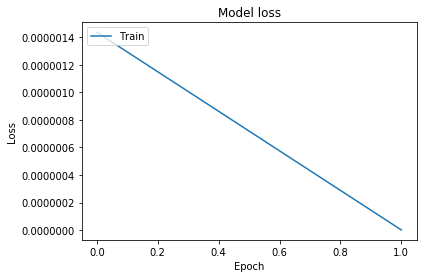

In [814]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [815]:
X_te_f[0]

array([-3.04493065e-08, -1.39344333e-07, -1.25006212e-07,  2.09757350e-07,
        8.45024787e-08,  1.13415949e-07, -9.01498531e-09,  1.22405155e-08,
        1.10684008e-07,  1.66225159e-08,  1.72419266e-08,  3.10900905e-08,
       -8.74221906e-09,  7.21320042e-08,  3.82988328e-08,  4.78062584e-09,
        5.53623754e-08,  7.89619918e-08,  4.09300600e-08, -4.58950923e-08,
        1.34986709e-07, -1.04559747e-09,  6.27715490e-08,  6.38788100e-08,
        6.37074746e-08, -4.47760111e-08,  1.18413931e-07,  7.50631705e-08,
       -1.69786551e-08, -2.49170257e-08,  3.07073468e-10, -1.21091089e-09,
        2.76811877e-09,  0.00000000e+00, -4.86002003e-07, -3.07632602e-07,
       -2.13736887e-07, -1.01289898e-07, -3.91967681e-08, -1.15756951e-07,
       -6.08961474e-08, -5.18003697e-08, -1.59969505e-07,  4.34597913e-08,
        3.76976911e-08, -3.24772455e-08, -5.67335376e-08, -3.22984109e-08,
       -3.31376037e-08, -1.05188513e-07,  1.18695944e-07, -1.45892327e-07,
        5.84871188e-09, -

In [816]:
def predict(model, row):
    return model.predict(np.array([row]))[0]

In [817]:
predict(model, X_te_f[0])

array([ 8.23471855e-05, -3.65699270e-06, -8.25345251e-06, -1.58894272e-06,
       -1.50281539e-06,  2.31351805e-07,  5.23241170e-06, -1.35258606e-05,
       -6.72189162e-06, -1.07534652e-06,  5.49469405e-07,  2.33077826e-05,
       -2.66253664e-07,  2.24414180e-05,  1.35965038e-05, -2.18160749e-05,
        3.79320700e-05,  1.22456277e-05,  4.90881066e-05, -9.48479283e-06,
       -2.81912053e-05, -8.12341896e-05,  5.31748174e-06,  4.50167863e-05,
        1.07277418e-04, -9.93438334e-07,  3.45927692e-05,  1.50807045e-06,
        1.08371751e-06, -3.84493251e-06, -4.82926771e-06, -5.09509209e-06,
       -1.76908679e-06,  4.52711028e-11, -4.81815441e-05, -4.86387944e-05,
       -9.07142748e-06,  2.64573396e-06, -2.27795499e-06,  7.45430043e-06,
        9.72584530e-07, -2.28534009e-05, -2.82078763e-05,  2.86484137e-05,
        3.25557339e-05,  5.08406010e-05, -5.77547371e-06, -1.18544940e-05,
       -1.34669517e-05, -2.00646737e-05, -9.78892785e-07,  7.23192215e-06,
        1.26649547e-05, -

Text(0, 0.5, 'value')

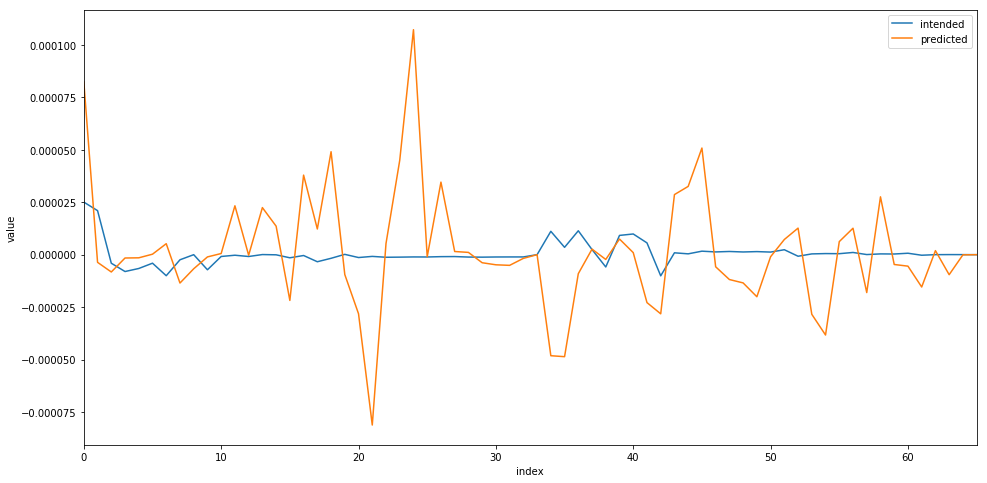

In [819]:
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 200

pd.Series(y_te_f[I]).plot.line(ax=ax, label='intended')

pred = pd.Series(predict(model, X_te_f[I]))

pred.plot.line(ax=ax, label='predicted')

# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')

## Time to evaluate performance

In [ ]:
# Til next time

In [ ]:
def unpack_peaks(peaks, N):
    df = pd.Series()
    
    for i in range(0, N):
        df = df.append(pd.Series([peaks[N + i]], index=[peaks[i]]))
        
    return df

In [ ]:
from numpy.fft import rfft, fftfreq, rfftfreq
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

MAGIC_NUMBER = 22050

def unpack_fft_features(row, N_PEAKS):  
    # Unpack peaks
    
    features_re = row[:2*N_PEAKS]
    features_im = row[2*N_PEAKS:]
    
    df = pd.Series()
    
    peaks_re = unpack_peaks(features_re, N_PEAKS)
    peaks_im = unpack_peaks(features_im, N_PEAKS)
    
    peaks = (peaks_re * complex(1, 0)).add(peaks_im * complex(0, 1))
    
    print(peaks)
    
    return []






    # Apply IFFT
    
    freq = rfftfreq(N_WINDOW_POINTS, 1./FD)
    max_freq = freq[-1]

    fft = rfft(wnd)

    df = pd.Series(fft)

    index = []

    for i in range(0, len(fft)):
        index = index + [(i / len(fft))]

    df.index = index

    

In [ ]:
I = 200

unpack_fft_features(predict(model, X_te_f[I]), N_PEAKS)